In [12]:
from art.attacks.evasion import PixelAttack
from art.estimators.classification import PyTorchClassifier

import torch
import numpy as np
from sklearn.datasets import fetch_openml
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from art.utils import load_mnist

In [10]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)
print(X.shape)


(70000, 784)


In [11]:
X = X.reshape(X.shape[0], 1, 28, 28).astype(np.float32)
print(X.shape)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

(70000, 1, 28, 28)


In [15]:
model = torch.load('mnistnet.pkl')

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [17]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 255),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10
)

In [ ]:
classifier.fit(X_train, y_train)

In [ ]:
#classifier.predict(X_test)

In [18]:
from art.attacks.evasion import PixelAttack

# Step 6: Generate adversarial test examples
attack = PixelAttack(classifier=classifier, max_iter=1)
X_test_adv = attack.generate(x=X_test[:2000])

with open("X_adv_pixel.txt", "w") as file:
    print(*X_test_adv, file=file, sep="\n")

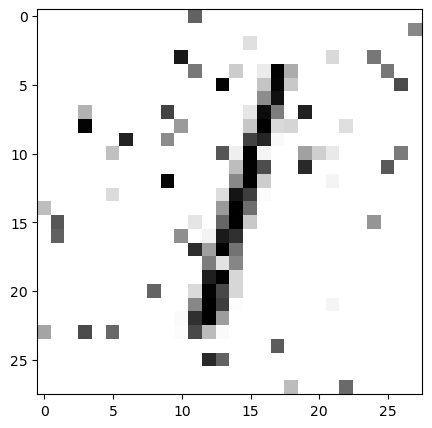

In [19]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.imshow(X_test_adv[2].reshape(28, 28), cmap='Greys')

In [20]:
# Step 7: Evaluate the ART classifier on adversarial test examples
test_dataset = TensorDataset(torch.from_numpy(np.array(X_test_adv)).float(),
                             torch.from_numpy(np.array(y_test[:2000])).long())
test_loader = DataLoader(test_dataset,
                         shuffle=True,
                         pin_memory=True,
                         num_workers=8,
                         drop_last=True,
                         batch_size=1)

correct = 0
total = 0
preds = []
for images, labels in test_loader:
    outputs = model(images)
    predicted = torch.argmax(outputs, dim=1)
    preds += predicted
    correct += (predicted == labels).sum().item()
    total += len(labels)
print(correct/total, correct, '/', total)

#8879

0.311 622 / 2000


Обучение

In [21]:
NUM_EPOCHS = 7
BATCH_SIZE = 128
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 28
NUM_CLASSES = 10
DEVICE_IDS = [0, 1, 2, 3]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
#X_train_adv = attack.generate(x=X_train)

In [23]:
train_dataset = TensorDataset(torch.from_numpy(np.array(X_test_adv[:1800])).float(),
                             torch.from_numpy(np.array(y_test[:1800])).long())
train_loader = DataLoader(train_dataset,
                         shuffle=True,
                         pin_memory=True,
                         num_workers=8,
                         drop_last=True,
                         batch_size=32)

In [24]:
def evaluate_model(nn_model):
    nn_model.eval()
    with torch.no_grad():
        correct_out = 0
        total_out = 0
        for pics, lbls in test_loader:
            out = nn_model(pics)
            pred = torch.argmax(out, dim=1)
            total_out += lbls.shape[0]
            correct_out += (pred == lbls).sum().item()

    loss_current = criterion(out, lbls)
    return correct_out / total_out, loss_current


In [25]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
print('Optimizer created')
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
print('LR Scheduler created')

Optimizer created
LR Scheduler created


In [26]:
import torch.nn.functional as F

accuracy_test_stat = []
accuracy_train_stat = []
loss_test_stat = []
loss_train_stat = []

print('Starting training...')
total_steps = 1
for epoch in range(NUM_EPOCHS):
    epoch_tr_accuracy = 0
    epoch_tr_loss = 0

    lr_scheduler.step()
    for imgs, classes in train_loader:
        imgs, classes = imgs.to(device), classes.to(device)

        # calculate the loss
        output = model(imgs)
        loss = F.cross_entropy(output, classes)

        # update the parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log the information and add to tensorboard
        if total_steps % 20 == 0:
            with torch.no_grad():
                predictions = torch.argmax(output, dim=1)
                accuracy = (predictions == classes).sum() / len(predictions)

                epoch_tr_accuracy = accuracy.item()
                epoch_tr_loss = loss.item()

                print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                      .format(epoch + 1, total_steps, loss.item(), epoch_tr_accuracy))

        if total_steps % 40 == 0:
            a, l = evaluate_model(model)
            accuracy_train_stat.append(epoch_tr_accuracy)
            accuracy_test_stat.append(a)

            loss_train_stat.append(epoch_tr_loss)
            loss_test_stat.append(l)
        total_steps += 1

    # print(accuracy_test_stat, accuracy_train_stat, loss_test_stat, loss_train_stat)

Starting training...


/Users/megame/opt/anaconda3/envs/mnist_nn/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1 	Step: 20 	Loss: 0.6612 	Acc: 0.71875
Epoch: 1 	Step: 40 	Loss: 0.8390 	Acc: 0.71875
Epoch: 2 	Step: 60 	Loss: 0.0936 	Acc: 1.0
Epoch: 2 	Step: 80 	Loss: 0.1054 	Acc: 0.96875
Epoch: 2 	Step: 100 	Loss: 0.2182 	Acc: 0.9375
Epoch: 3 	Step: 120 	Loss: 0.0838 	Acc: 0.96875
Epoch: 3 	Step: 140 	Loss: 0.0566 	Acc: 1.0
Epoch: 3 	Step: 160 	Loss: 0.0313 	Acc: 1.0
Epoch: 4 	Step: 180 	Loss: 0.0153 	Acc: 1.0
Epoch: 4 	Step: 200 	Loss: 0.1540 	Acc: 0.9375
Epoch: 4 	Step: 220 	Loss: 0.1226 	Acc: 0.96875
Epoch: 5 	Step: 240 	Loss: 0.0371 	Acc: 0.96875
Epoch: 5 	Step: 260 	Loss: 0.0055 	Acc: 1.0
Epoch: 5 	Step: 280 	Loss: 0.0015 	Acc: 1.0
Epoch: 6 	Step: 300 	Loss: 0.0079 	Acc: 1.0
Epoch: 6 	Step: 320 	Loss: 0.0122 	Acc: 1.0
Epoch: 7 	Step: 340 	Loss: 0.0037 	Acc: 1.0
Epoch: 7 	Step: 360 	Loss: 0.0247 	Acc: 1.0
Epoch: 7 	Step: 380 	Loss: 0.0009 	Acc: 1.0


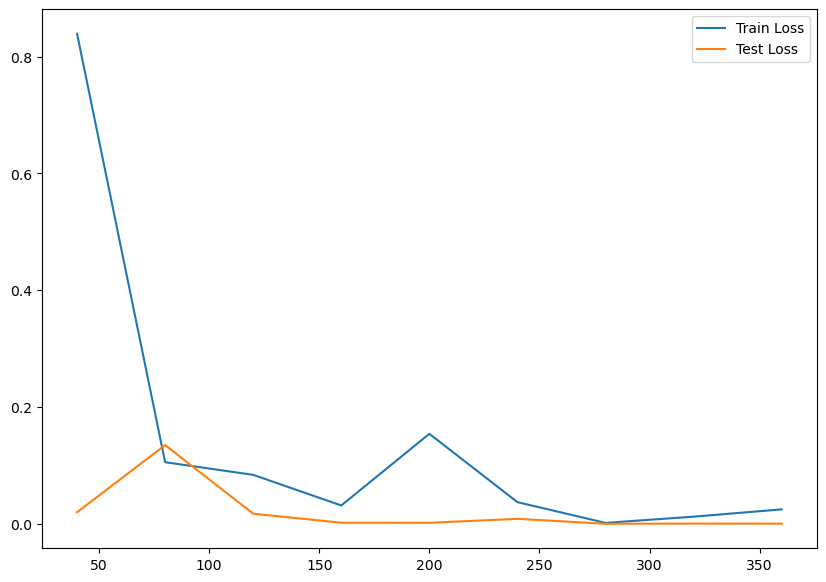

In [27]:
epochs = np.multiply(range(1, len(loss_train_stat) + 1), 40)
plt.figure(figsize=(10, 7))
plt.plot(epochs, loss_train_stat)
plt.plot(epochs, loss_test_stat)
plt.legend(["Train Loss", "Test Loss"])
plt.show()

[0.9165, 0.9515, 0.965, 0.9855, 0.984, 0.9775, 0.9915, 0.991, 0.9895]


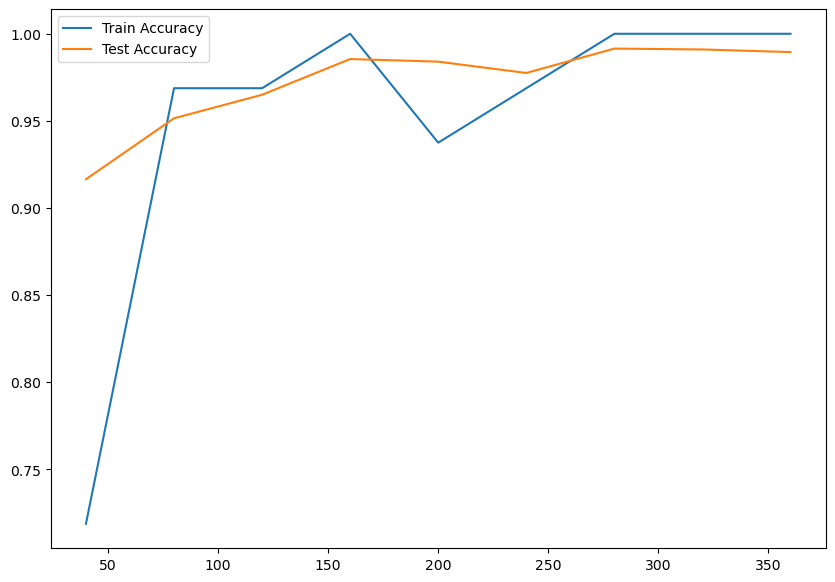

In [28]:
epochs = np.multiply(range(1, len(loss_train_stat) + 1), 40)
plt.figure(figsize=(10, 7))
print(accuracy_test_stat)
plt.plot(epochs, accuracy_train_stat)
plt.plot(epochs, accuracy_test_stat)
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

In [29]:
torch.save(model, 'mnistnet_art_pixel.pkl')

In [30]:
test_dataset = TensorDataset(torch.from_numpy(np.array(X_test_adv)).float(),
                             torch.from_numpy(np.array(y_test[:2000])).long())
test_loader = DataLoader(test_dataset,
                         shuffle=True,
                         pin_memory=True,
                         num_workers=8,
                         drop_last=True,
                         batch_size=1)

correct = 0
total = 0
preds = []
for images, labels in test_loader:
    outputs = model(images)
    predicted = torch.argmax(outputs, dim=1)
    preds += predicted
    correct += (predicted == labels).sum().item()
    total += len(labels)
print(correct/total, correct, '/', total)


0.993 1986 / 2000
